In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()

In [4]:
import matplotlib.pyplot as plt

def plot_experiment(node_data):
    plt.rcParams["figure.figsize"] = (8,5)
    
    a,b,c,d = node_data
    
    plt.scatter(a.humidity, a.temperature, marker= ".", label="pi2", alpha =0.5)
    plt.scatter(b.humidity, b.temperature, marker = "v", label="pi3", alpha=0.5)
    plt.scatter(c.humidity, c.temperature, marker = "^", label="pi4", alpha=0.5)
    plt.scatter(d.humidity, d.temperature, marker = "*", label="pi5", alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel="Humidity")
    plt.ylabel(ylabel="Temperature")
    plt.show()

def plot_experiments():
    for i in range(1,4):
        node_data = get_node_data(data, experiment =i)
        plot_experiment(node_data)

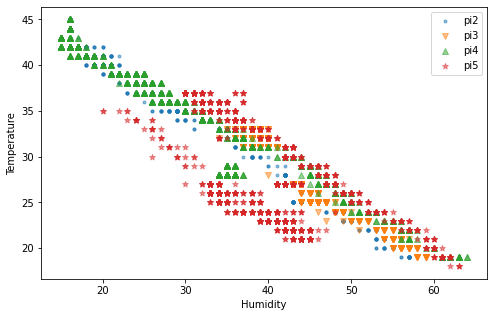

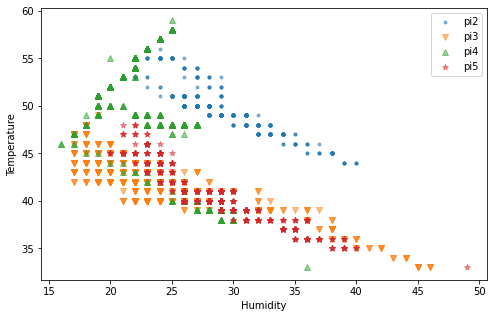

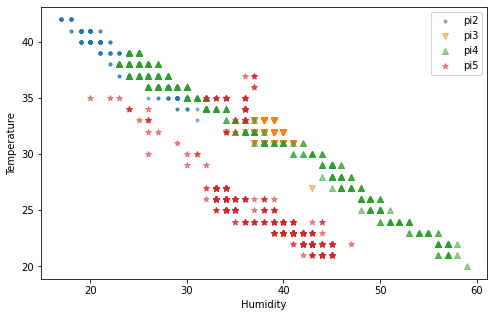

In [5]:
plot_experiments()

In [ ]:
def construct_similar_dissimilar_sample_sets(samples, experiment):
    sa, sb, sc, sd = samples
    if experiment == 1:
        similar_sets = [sa,sc]
        dissimilar_sets = [sb,sd]
    elif experiment == 2:
        similar_sets = [sb,sd]
        dissimilar_sets = [sa,sc]
    else:
        similar_sets = [sb, sc, sd]
        dissimilar_sets = [sa]
    
    return similar_sets, dissimilar_sets

In [4]:
from itertools import combinations as comb
from maximum_mean_discrepancy import MMD, get_tensor_samples
from prettytable import PrettyTable
    
def print_mmd(x,y, kernel, kernel_bandwidth):  
    result = MMD(x,y, kernel, kernel_bandwidth)
    print(f"mmd result of X and Y is {result.item()}")

def avg_similarity_disimilarity_mmd(samples, similar_sets, dissimilar_sets, kernel, kernel_bandwidth):
    # The similar set contains the nodes that are similar to each other and dissimilar to the the dissimilar set.
    # The dissimilar set is dissimilar to similar set nodes but they could be similar to each other.
    
    s = PrettyTable(['Nodes', 'Similar MMD'])
    d = PrettyTable(['Nodes', 'Dissimilar MMD'])
    
    combos = comb(range(len(similar_sets)),2)
    similar_mmds = []
    for combo in combos:
        x = similar_sets[combo[0]]
        y = similar_sets[combo[1]]
        sx = samples[x]
        sy = samples[y]
        mmd = MMD(sx,sy, kernel, kernel_bandwidth)
        similar_mmds.append(mmd)
        s.add_row([(x,y), mmd])

    ## calculate the mmd between each dissimilar set and the similar sets
    dissimilar_mmds = []
    for i in range(len(dissimilar_sets)):
        x = dissimilar_sets[i]
        sx = samples[x]
        for j in range(len(similar_sets)):
            y = similar_sets[j]
            sy = samples[y]
            mmd = MMD(sx,sy, kernel, kernel_bandwidth)
            dissimilar_mmds.append(mmd)
            d.add_row([(x,y), mmd])
    
    ## calculate the mmd between the dissimilar sets as they could be dissimilar/similar to each other
    if len(dissimilar_sets) > 1:
        combos = comb(range(len(dissimilar_sets)),2)
        for combo in combos:
            x = dissimilar_sets[combo[0]]
            y = dissimilar_sets[combo[1]]
            sx = samples[x]
            sy = samples[y]
            mmd = MMD(sx,sy, kernel, kernel_bandwidth)
            if mmd > np.mean(similar_mmds) +  np.mean(similar_mmds) * 0.15:
                dissimilar_mmds.append(mmd)
                d.add_row([(x,y), mmd])
            else: 
                similar_mmds.append(mmd)
                s.add_row([(x,y), mmd])

    print(s)
    print(d)
    print()
    return np.mean(similar_mmds), np.mean(dissimilar_mmds)

def bandwidth_experiment(samples, similar_sets, dissimilar_sets, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd = avg_similarity_disimilarity_mmd(samples, similar_sets, dissimilar_sets, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
    print(t)
    print()

## Observations

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [5]:
m = 200
samples = get_tensor_samples(data, experiment=1, sample_size=m)

In [6]:
similar_sets = ["pi2","pi4"]
dissimilar_sets = ["pi3","pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(2.5545) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(31.0114) |
| ('pi3', 'pi4') | tensor(24.2040) |
| ('pi5', 'pi2') | tensor(22.8385) |
| ('pi5', 'pi4') | tensor(17.0792) |
| ('pi3', 'pi5') |  tensor(3.7951) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(7.6637) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(93.0341) |
| ('pi3', 'pi4') | tensor(72.6120) |
| ('pi5', 'pi2') | tensor(68.5154) |
| ('pi5', 'pi4') | tensor(51.2374) |
| ('pi3', 'pi5') | tensor(11.3853) |
+

In [10]:
similar_sets = ["pi2","pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(29.0285) |
| ('pi2', 'pi4') | tensor(28.0280) |
| ('pi3', 'pi4') |  tensor(2.5592) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(41.6369) |
| ('pi5', 'pi3') |  tensor(7.1915) |
| ('pi5', 'pi4') |  tensor(6.3341) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(87.0856) |
| ('pi2', 'pi4') | tensor(84.0837) |
| ('pi3', 'pi4') |  tensor(7.6772) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor(124.9106) |
| ('pi5', 'pi3') | tensor(21.5746)  |
| ('pi5', 'pi4') | tens

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [8]:
samples = get_tensor_samples(data, experiment=3, sample_size=m)

In [11]:
similar_sets = ["pi3", "pi4"]
dissimilar_sets = ["pi2", "pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi4') | tensor(2.5592) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(29.0285) |
| ('pi2', 'pi4') | tensor(28.0280) |
| ('pi5', 'pi3') |  tensor(7.1915) |
| ('pi5', 'pi4') |  tensor(6.3341) |
| ('pi2', 'pi5') | tensor(41.6368) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi4') | tensor(7.6772) |
+----------------+----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi2', 'pi3') | tensor(87.0856)  |
| ('pi2', 'pi4') | tensor(84.0837)  |
| ('pi5', 'pi3') | tensor(21.5746)  |
| ('pi5', 'pi4') | tensor(19.0022)  |
| ('pi2', 'pi5') | tensor(124.9

In [12]:
similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(29.0285) |
| ('pi2', 'pi4') | tensor(28.0280) |
| ('pi3', 'pi4') |  tensor(2.5592) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(41.6369) |
| ('pi5', 'pi3') |  tensor(7.1915) |
| ('pi5', 'pi4') |  tensor(6.3341) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(87.0856) |
| ('pi2', 'pi4') | tensor(84.0837) |
| ('pi3', 'pi4') |  tensor(7.6772) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor(124.9106) |
| ('pi5', 'pi3') | tensor(21.5746)  |
| ('pi5', 'pi4') | tens

### Experiment 2

In [13]:
samples = get_tensor_samples(data, experiment=2, sample_size=m)

In [14]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(5.4166) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(11.3883) |
| ('pi2', 'pi5') | tensor(12.4775) |
| ('pi4', 'pi3') | tensor(11.9864) |
| ('pi4', 'pi5') | tensor(19.4190) |
| ('pi2', 'pi4') |  tensor(6.6112) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(16.2496) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(34.1650) |
| ('pi2', 'pi5') | tensor(37.4327) |
| ('pi4', 'pi3') | tensor(35.9592) |
| ('pi4', 'pi5') | tensor(58.2569) |
| ('pi2', 'pi4') | tensor(19.8333

## Classifier Experiments

For now let's only consider the data from experiment 2 because they match both the plot and MMD results that pi3 and pi5 have a similar distribution and pi2 and pi4 are the dissimilar nodes.

In [15]:
samples = get_tensor_samples(data, experiment=2, sample_size=200)

In [16]:
avg_similarity, avg_dissimilarity = avg_similarity_disimilarity_mmd(samples, ["pi3", "pi5"], ["pi2", "pi4"], "rbf", 10)

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(0.4636) |
| ('pi2', 'pi4') | tensor(0.4464) |
+----------------+----------------+
+----------------+----------------+
|     Nodes      | Dissimilar MMD |
+----------------+----------------+
| ('pi2', 'pi3') | tensor(0.7743) |
| ('pi2', 'pi5') | tensor(0.9523) |
| ('pi4', 'pi3') | tensor(0.5410) |
| ('pi4', 'pi5') | tensor(0.7317) |
+----------------+----------------+



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture

def LR():
    return LinearRegression()

def SVR():
    return SVR()

def GM():
    return GaussianMixture(n_components=1)

def fit_clf(clf, data):
    clf.fit(data)

lr = LR()
# svr = SVR()

In [ ]:
node_data = get_node_data(data, experiment = 2)

In [ ]:
from sklearn.model_selection import train_test_split
models = {}
for i in range(2,6):
    model = GM()
    train, test = train_test_split(node_data[i-2])
    model.fit(train)
    print(f"Model Accuracy for node pi{i}: {model.score(test)}")
    models["pi"+str(i)] = [model, train, test]

In [ ]:
data